# Exploring at Raw Data

Looking at the raw data

## Packages

In [1]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Access Object

Path Management

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CreditMomentum\root\src")
from CreditDataCollect import CreditDataCollect

# CDS Tickers

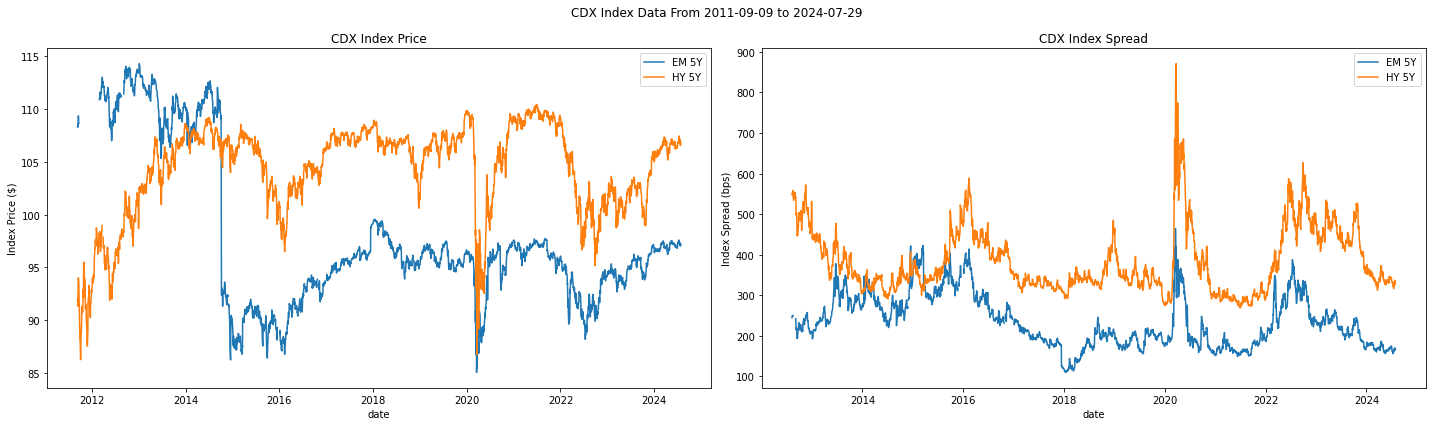

In [3]:
def plot_cds_data() -> plt.Figure: 
    
    df_tmp = (CreditDataCollect().get_cds().assign(
        name = lambda x: x.unique_name.str.split("X").str[-1].str.strip()))

    namer = {
        "PRC" : "CDX Index Price",
        "SPRD": "CDX Index Spread"}

    fig, axes = plt.subplots(ncols = len(namer.keys()), figsize = (20,6))
    for name, ax in zip(namer.keys(), axes.flatten()):

        if name == "PRC": ylabel = "Index Price ($)"
        else            : ylabel = "Index Spread (bps)"

        (df_tmp.query(
            "variable == @name")
            [["date", "value", "name"]].
            rename(columns = {"name": ""}).
            pivot(index = "date", columns = "", values = "value").
            plot(
                ax     = ax,
                title  = namer[name],
                ylabel = ylabel))

    fig.suptitle("CDX Index Data From {} to {}".format(
        df_tmp.date.min(),
        df_tmp.date.max()))

    plt.tight_layout()
    
plot_cds_data()

## Credit ETFs

In [4]:
df_tmp = CreditDataCollect().get_credit_etfs()

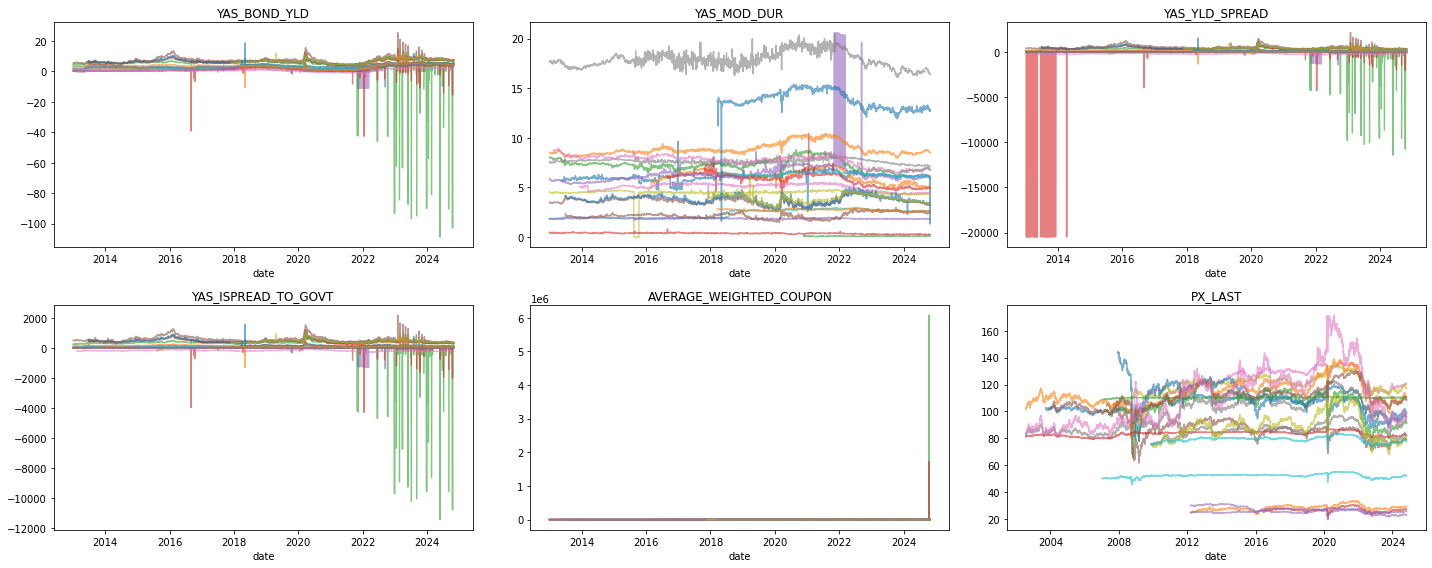

In [14]:
variables = df_tmp.variable.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 3, figsize = (20,8))

for variable, ax in zip(variables, axes.flatten()):
    
    (df_tmp.query(
        "variable == @variable")
        [["security", "date", "value"]].
        pivot(index = "date", columns = "security", values = "value").
        sort_index().
        plot(
            ax     = ax,
            legend = False,
            alpha  = 0.6,
            title  = variable))
    
plt.tight_layout()

C:\Users\Diego\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


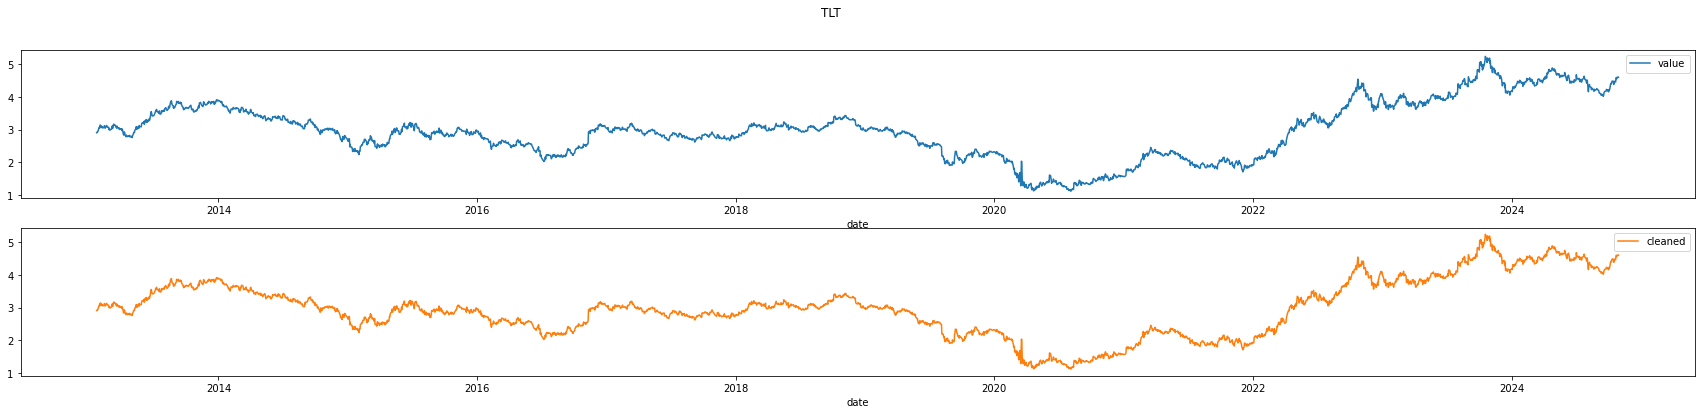

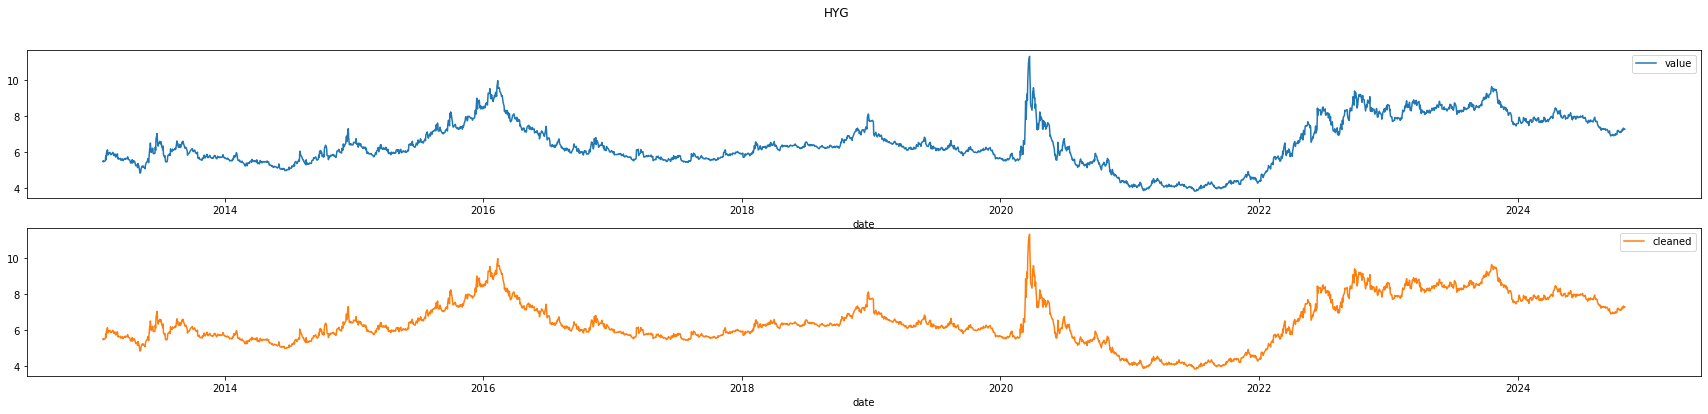

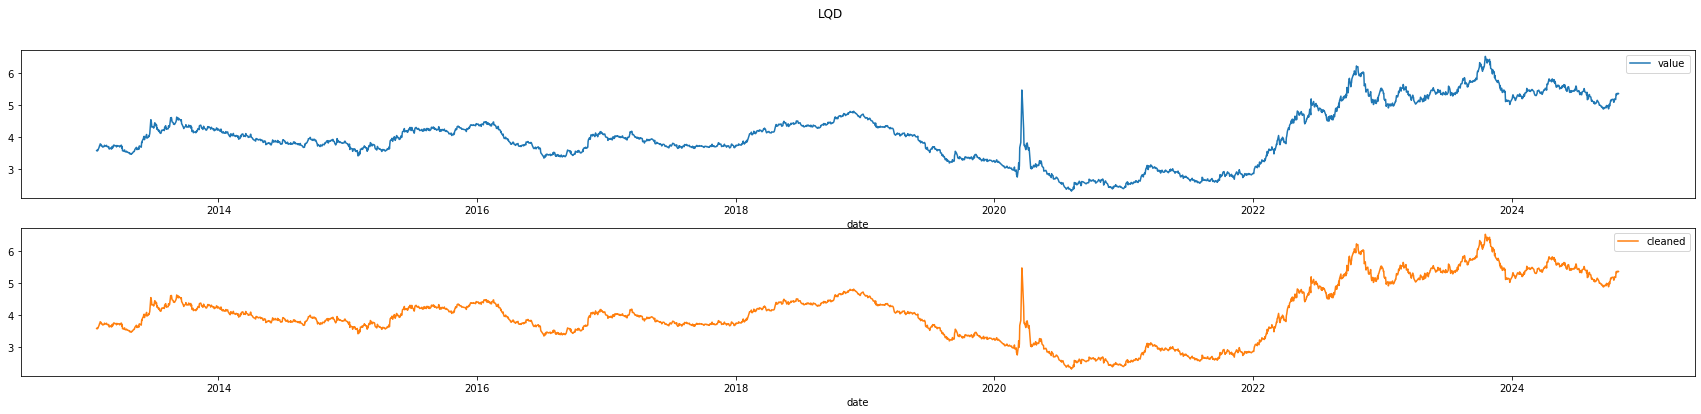

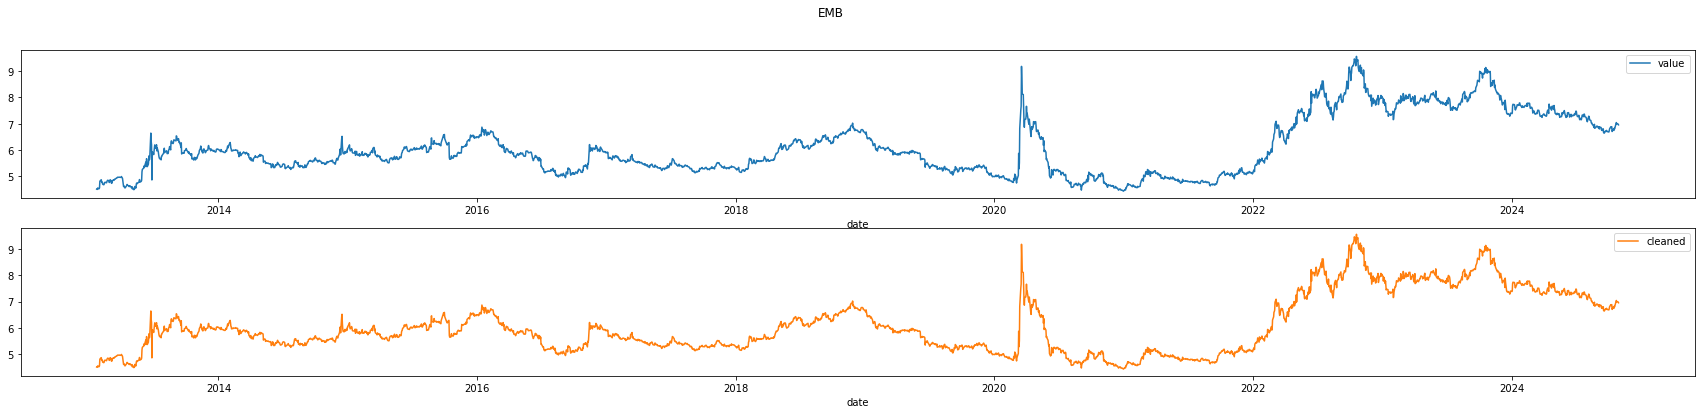

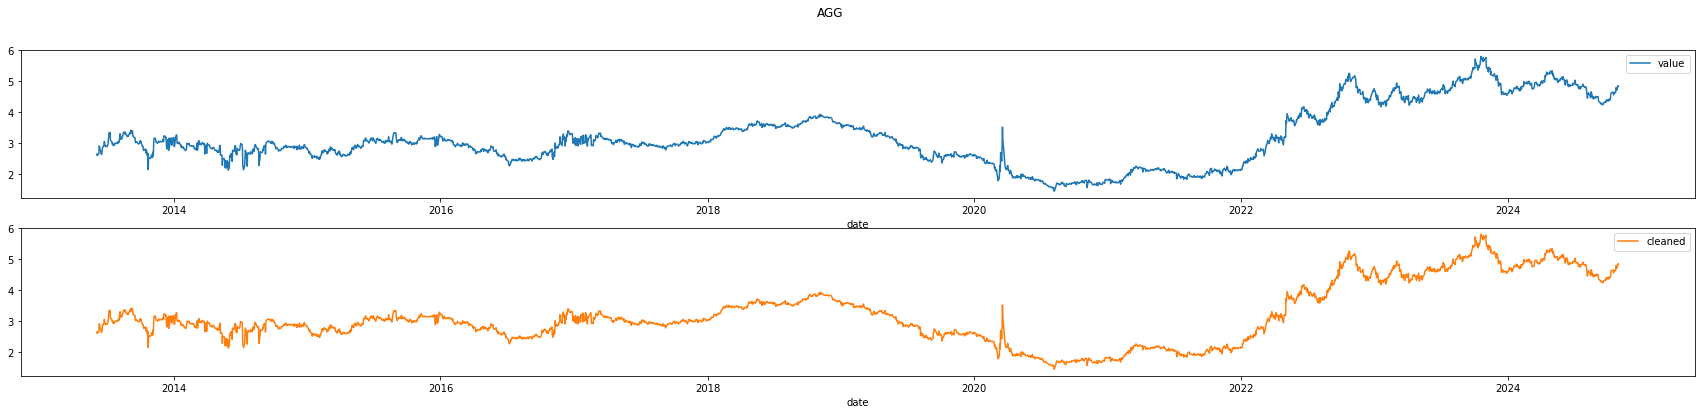

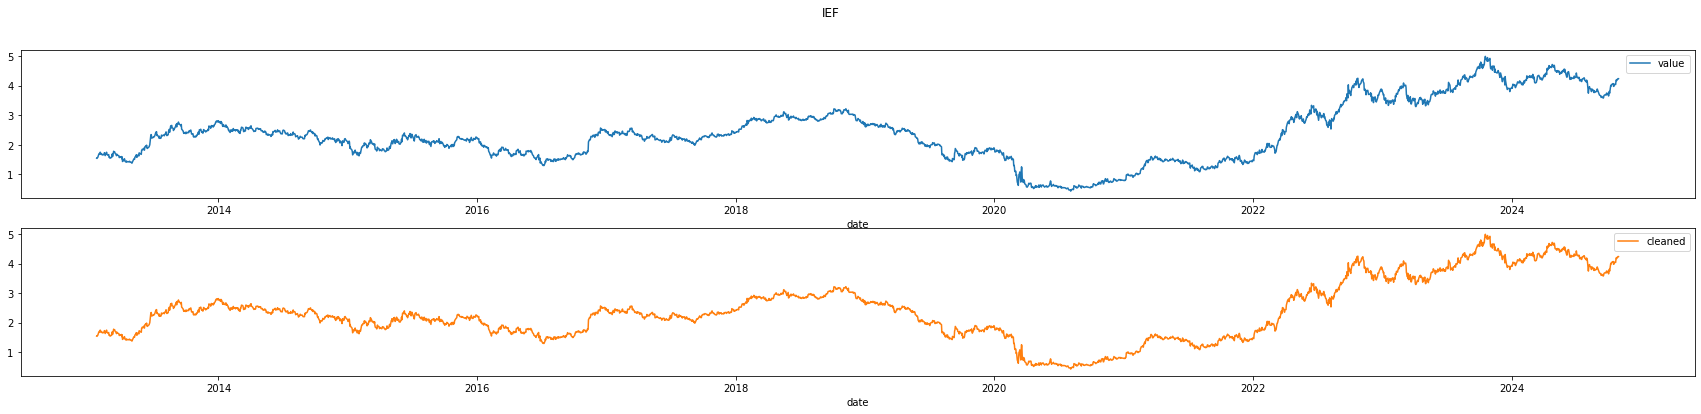

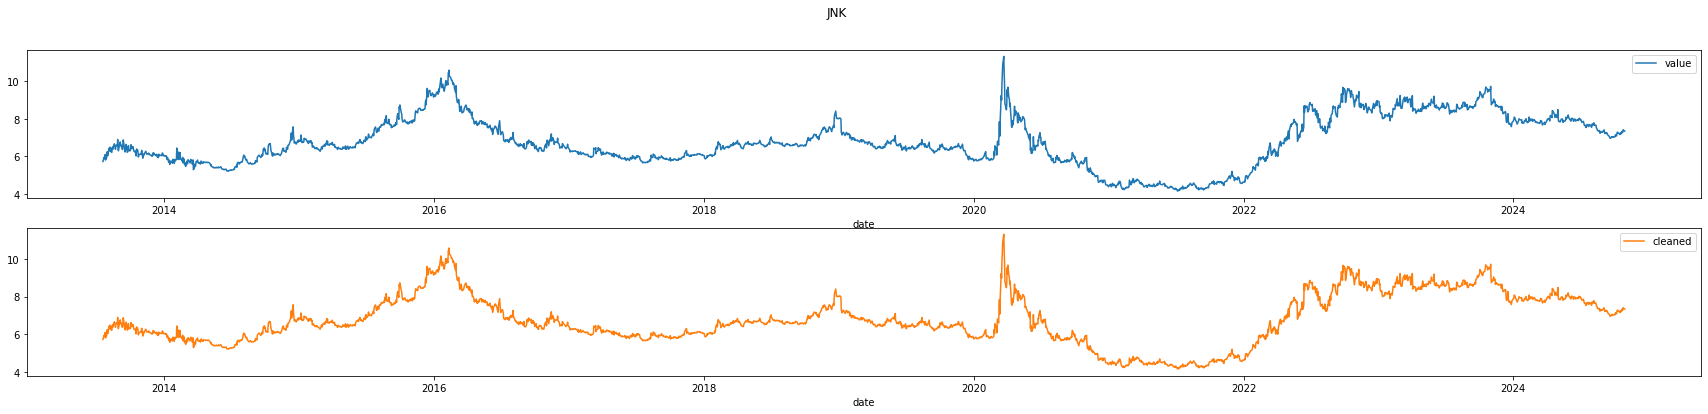

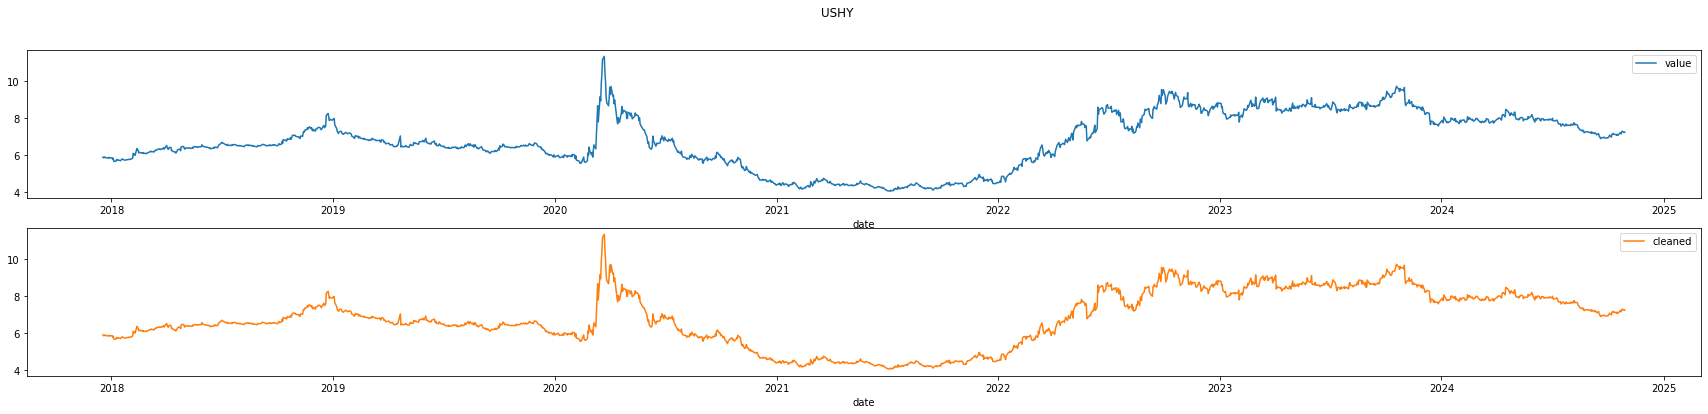

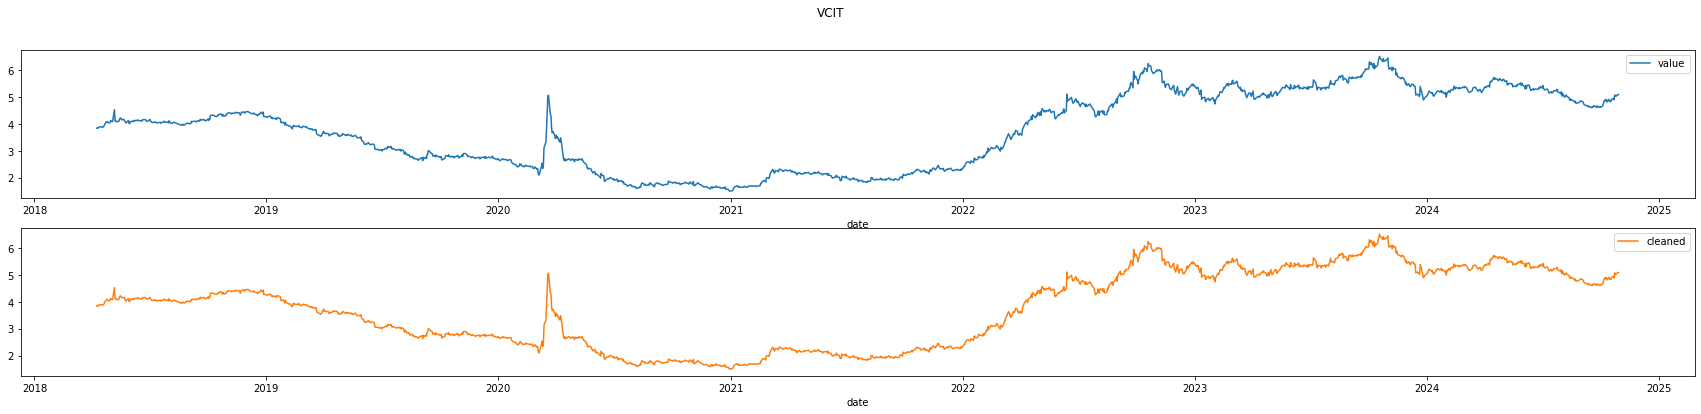

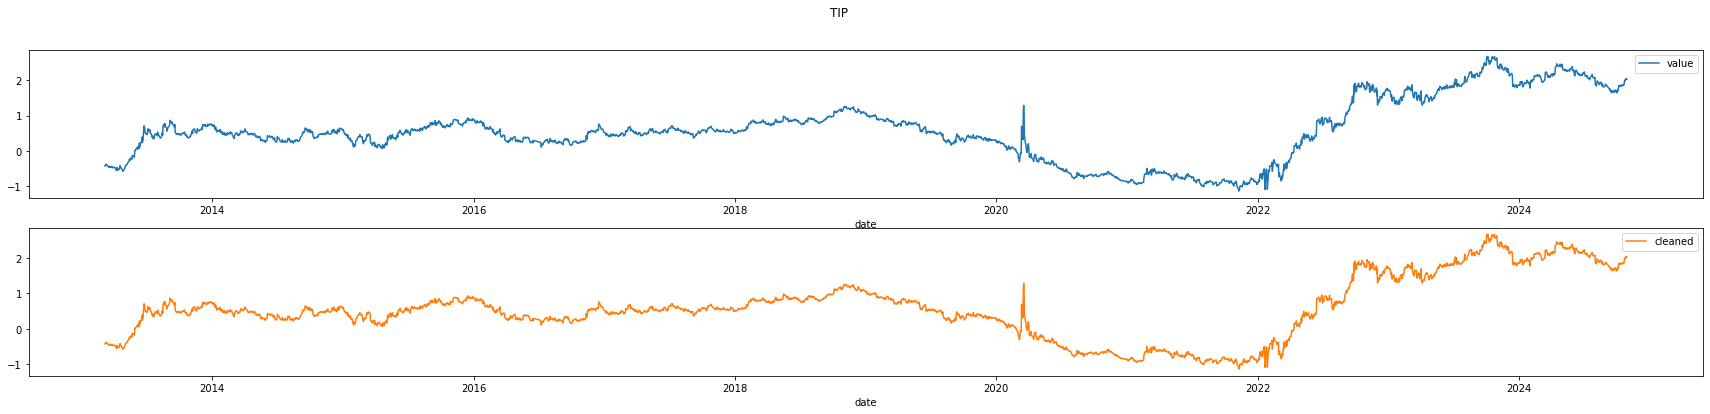

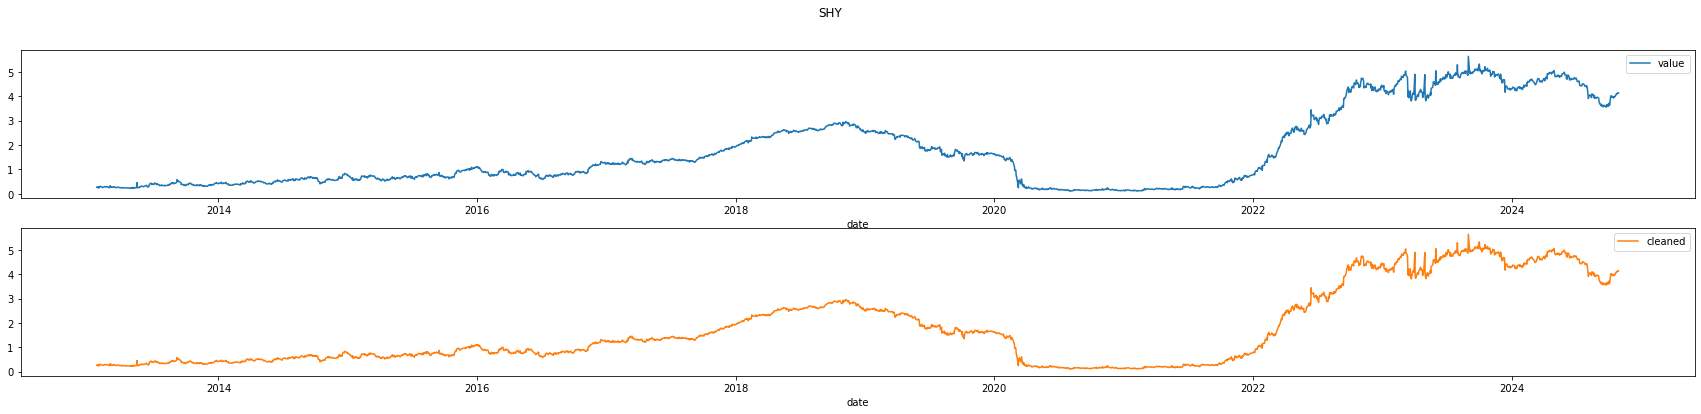

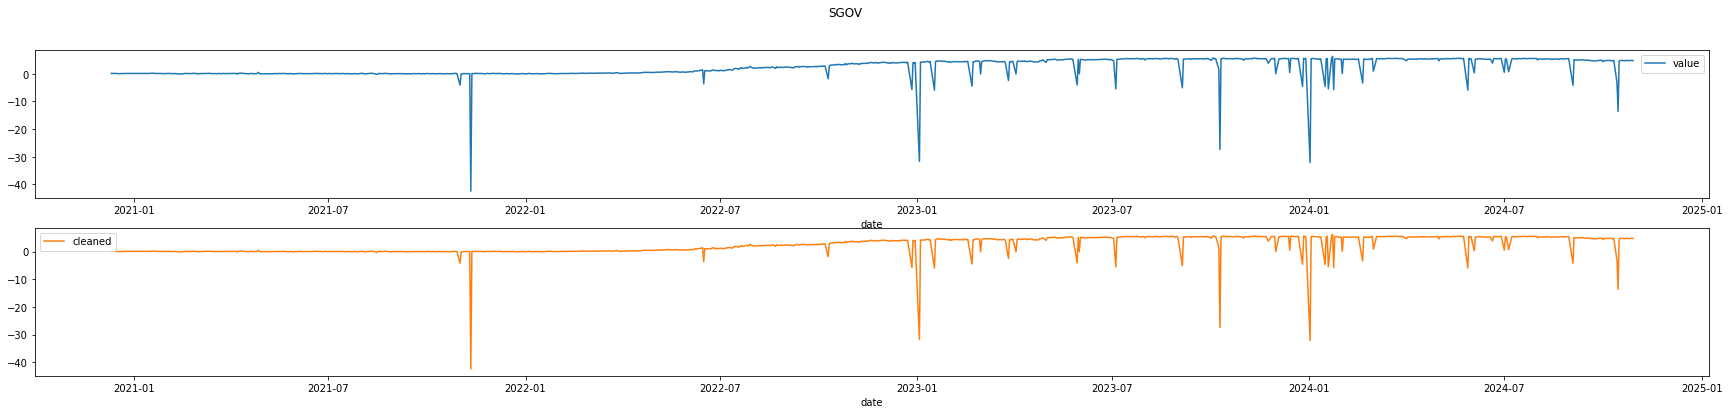

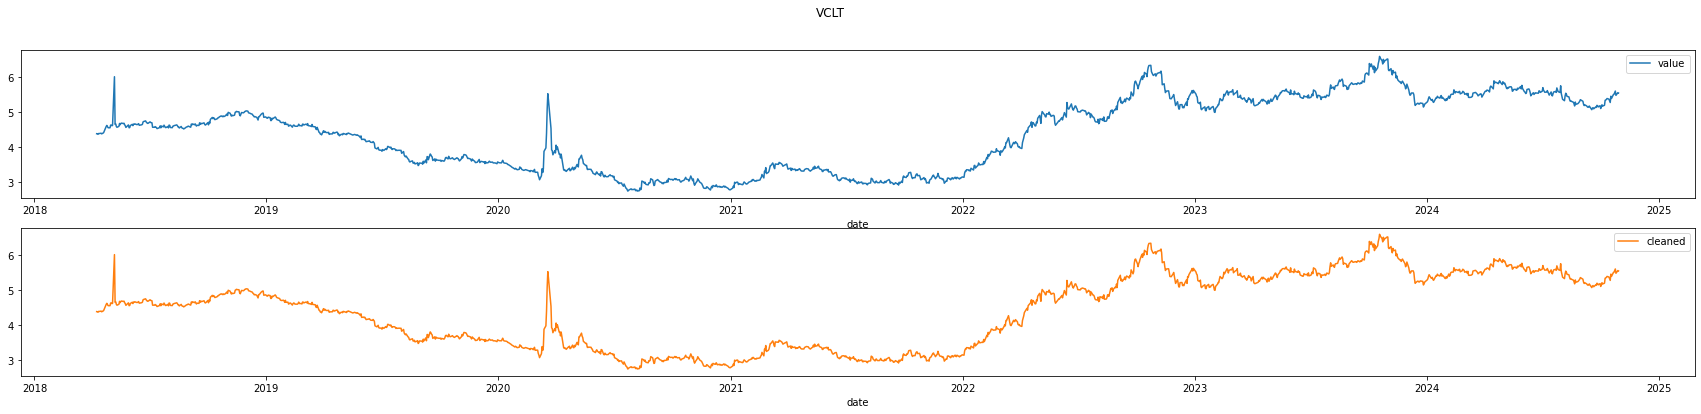

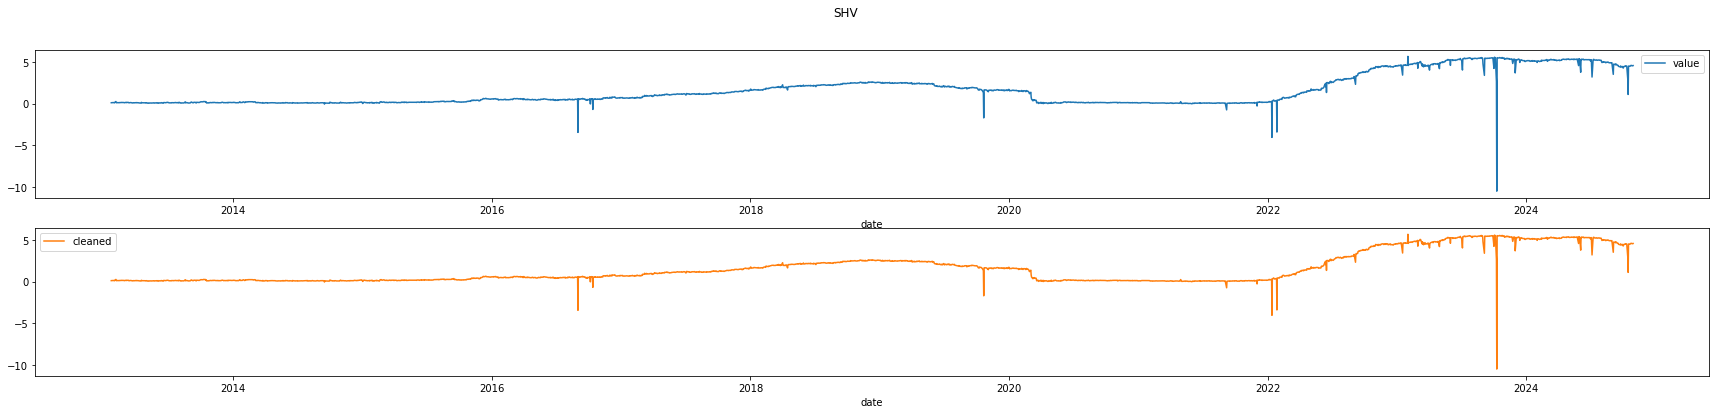

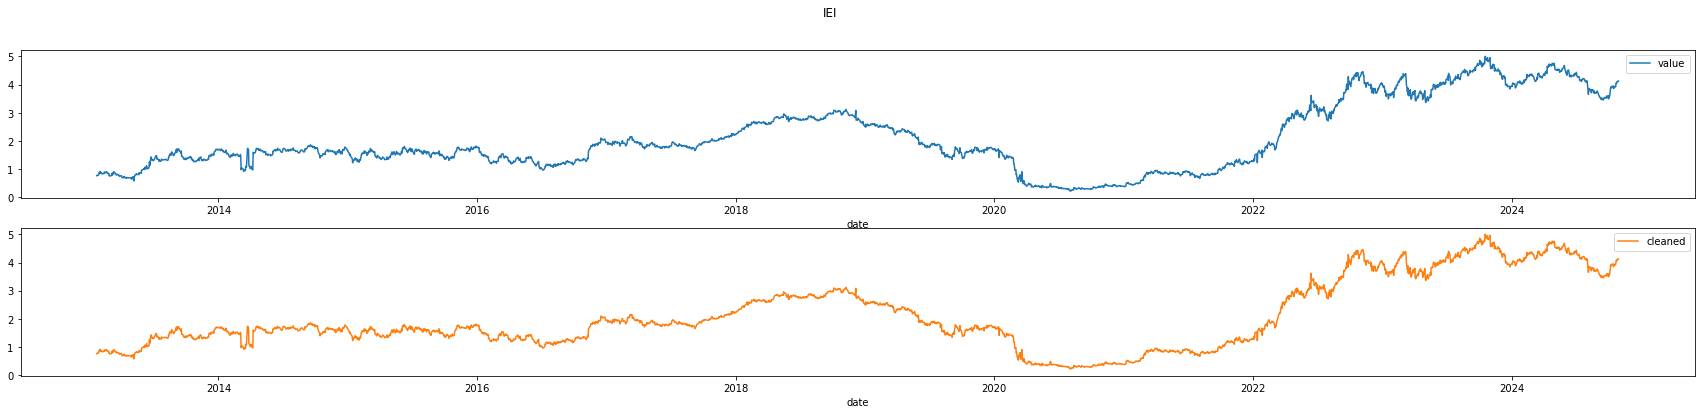

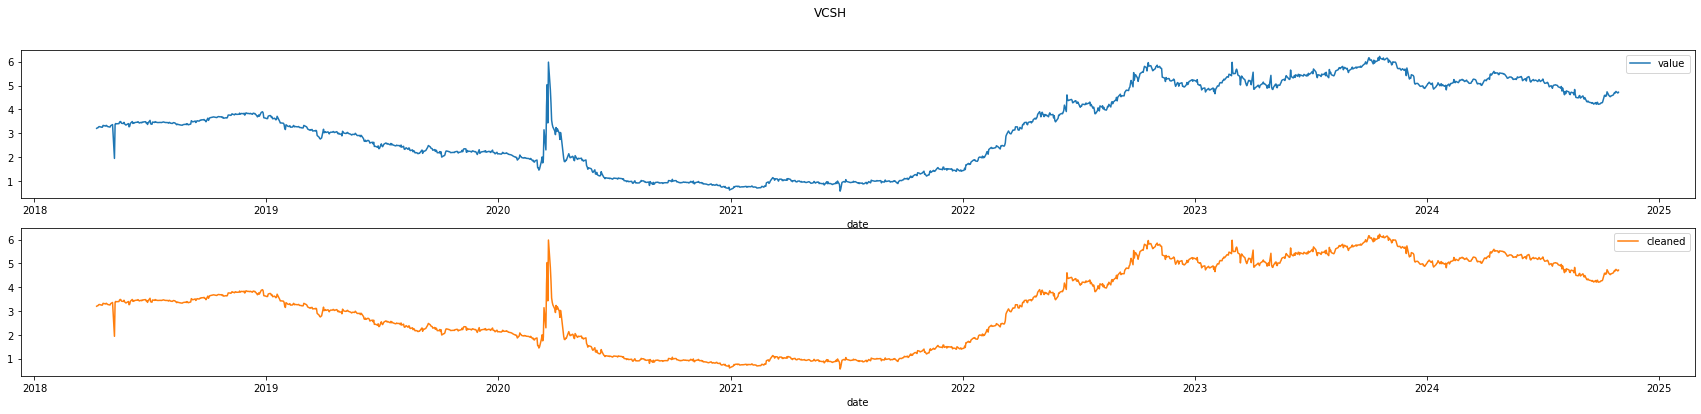

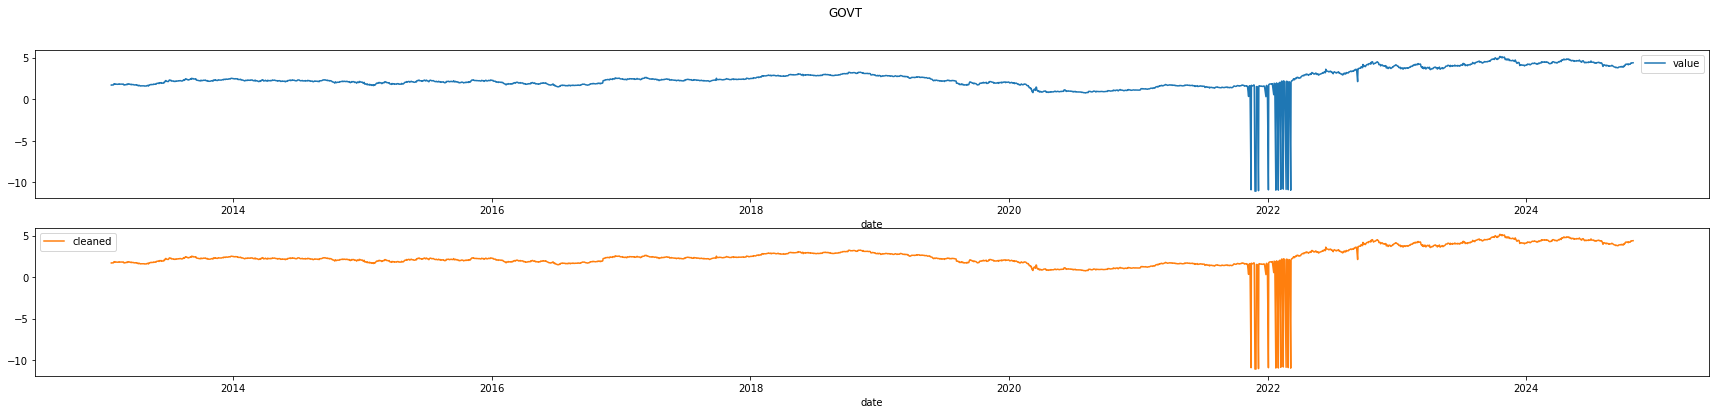

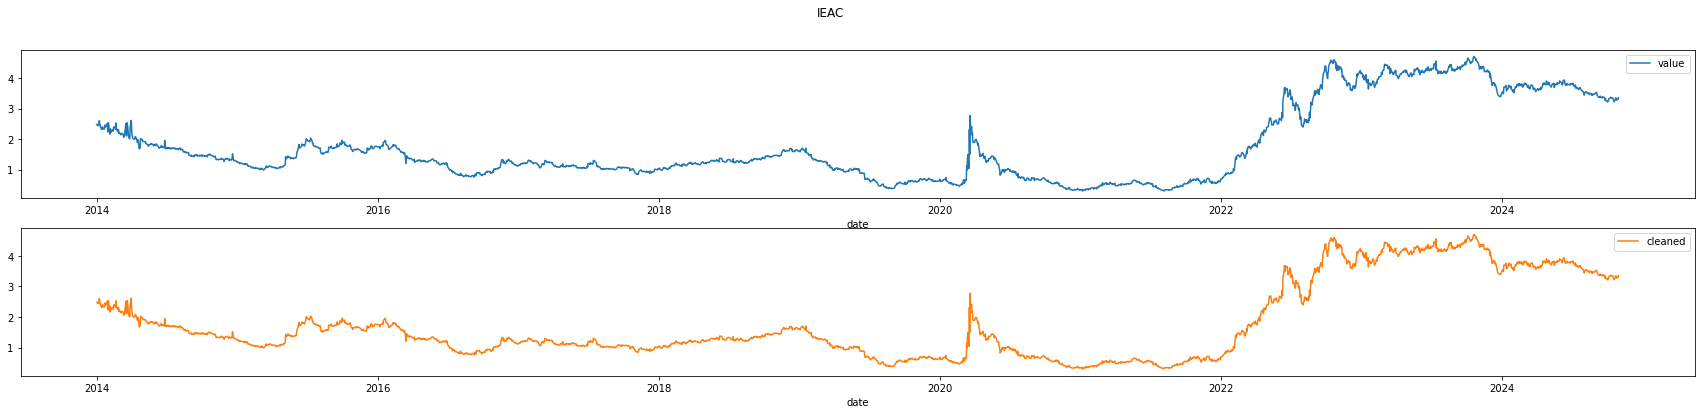

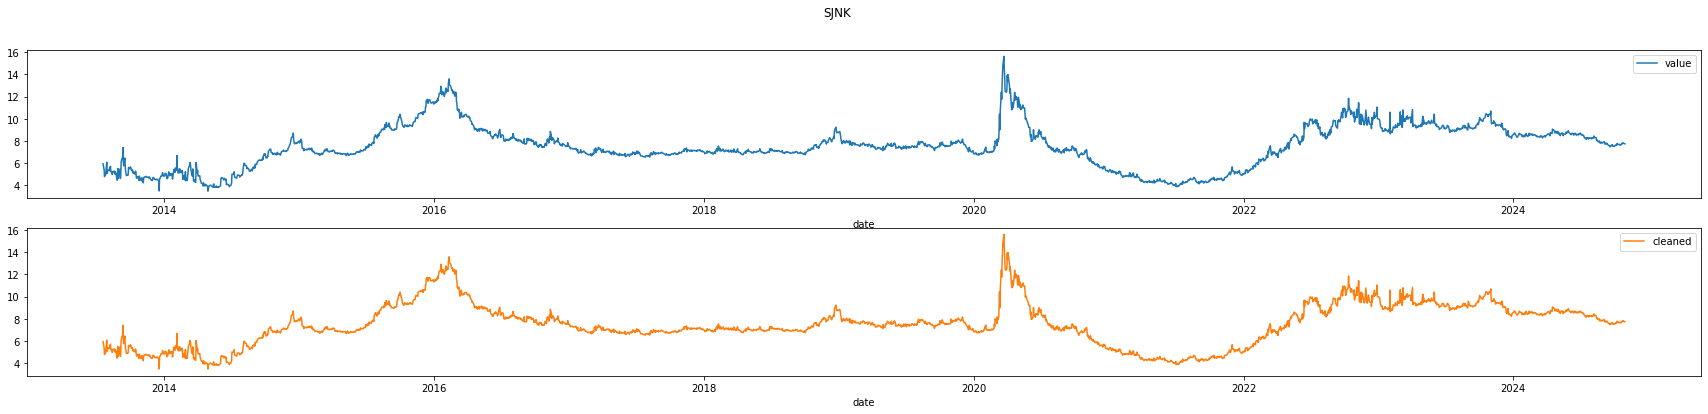

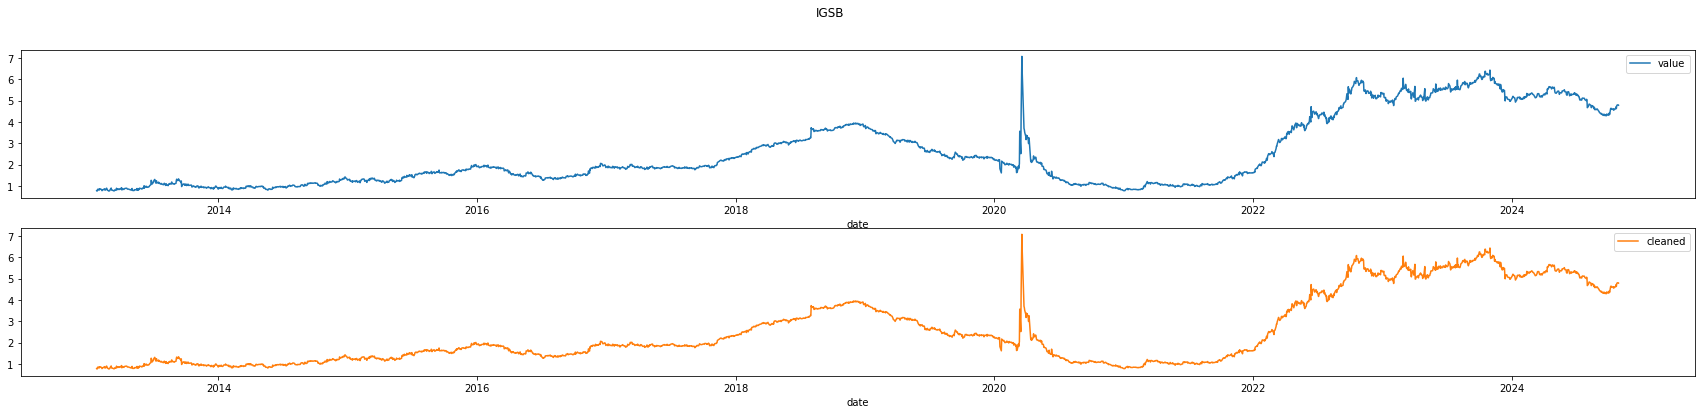

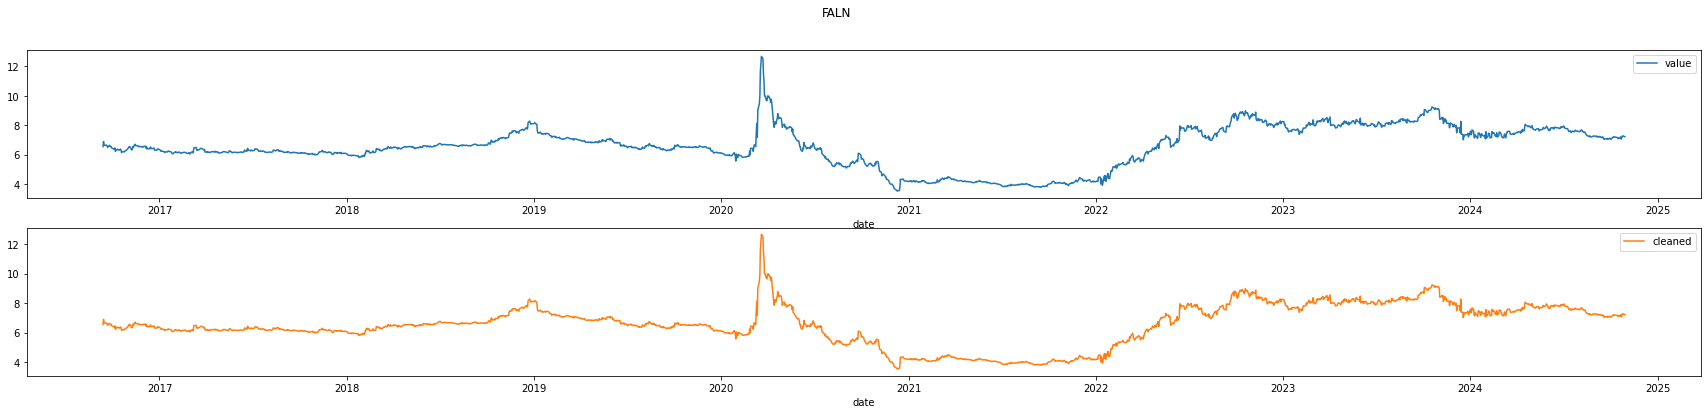

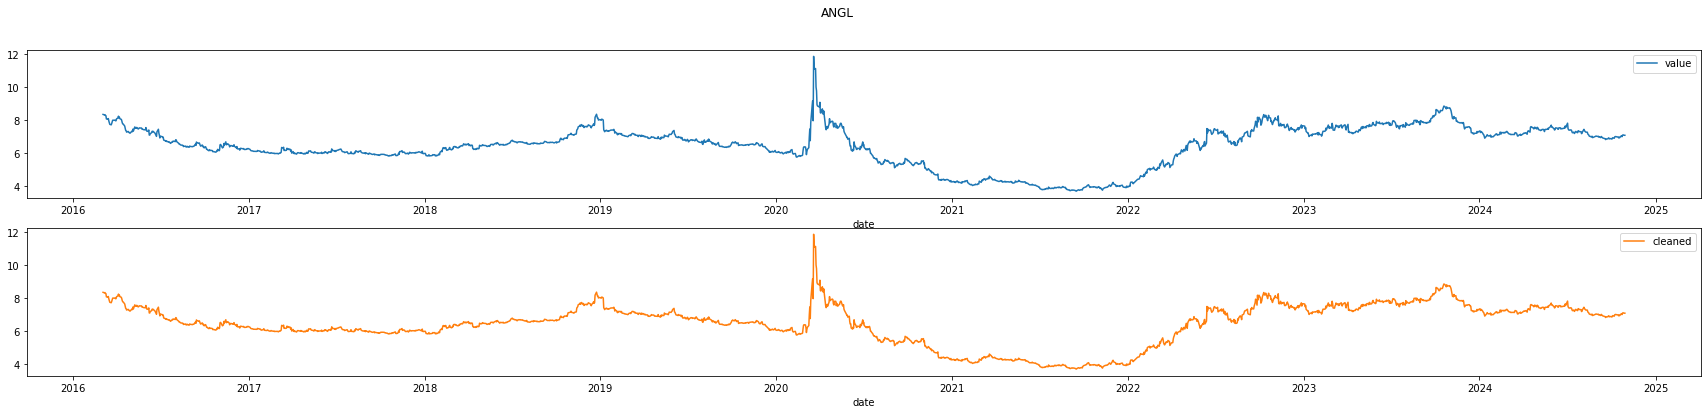

In [102]:
def _get_zscore(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_mean = lambda x: x.value.rolling(window = window).mean(),
            roll_std  = lambda x: x.value.rolling(window = window).std(),
            z_score   = lambda x: np.abs((x.value - x.roll_mean) / x.roll_std)).
        dropna())
    
    return df_out

window1 = 10
securities = df_tmp.security.drop_duplicates().to_list()

window2 = 5
for security in securities: 

    (df_tmp.query(
        "variable == 'YAS_BOND_YLD'").
        query("security == @security").
        groupby("security").
        apply(_get_zscore, window1).
        reset_index(drop = True).
        assign(value = lambda x: np.where(x.z_score > 2, x.roll_mean, x.value)).
        groupby("security").
        apply(_get_zscore, window2).
        assign(cleaned = lambda x: np.where(x.z_score > 2, x.roll_mean, x.value)).   
        set_index("date")
        [["value", "cleaned"]].
        plot(subplots = True, figsize = (30,6), sharex = False, title = security))